<a href="https://colab.research.google.com/github/siddas18/Natural-Disaster-Damage-Prediction/blob/Kartik/Data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
## Generic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt
from math import sqrt, isnan
import requests
import gzip
from functools import reduce
import scipy as scp
import seaborn as sns
import scipy.interpolate

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

## Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


## Metrics
from sklearn.metrics import mean_squared_error, r2_score, f1_score


import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

In [58]:
def get_NOAA_data():
    
    URL = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
    r = requests.get(URL)
    file_names = pd.read_html(r.text)[0]['Name']
    events_file_names = file_names[file_names.str.contains("details",na=False)]
    noaa_list = []
    
    print("Extracting CSV files...")
    for file in events_file_names:
        full_URL = URL + file
        with gzip.open(requests.get(full_URL, stream=True).raw) as f:
            noaa_list.append(pd.read_csv(f))
        
    df = pd.concat(noaa_list)
    
    print("Completed")
    return df

def pickle_source_data():
    noaa_source_df = get_NOAA_data()
    home_dir = os.getcwd()
    data_dir = os.path.join(home_dir, "Data")
    try:
        os.mkdir(data_dir)
        os.chdir(data_dir)
    except OSError:
        os.chdir(data_dir)
        for file in os.listdir():
            os.remove(file)
    noaa_source_df.to_pickle('noaa_source_data.pkl')
    os.chdir(home_dir)
    return noaa_source_df

NOAA_df = pickle_source_data()
    

Extracting CSV files...
Completed


In [ ]:
# pickle_df = pd.read_pickle('Data/noaa_source_data.pkl')

In [148]:
NOAA_df = pd.read_pickle('/content/drive/MyDrive/noaa_source_data.pkl')

In [121]:
def replace_str2num(x):
    if type(x) == float or type(x) == int:
        return float(x)
    num = 1 if x[:-1] == '' else x[:-1]        
    if x[-1] == 'T':
        return float(num) * 1000000000000
    elif x[-1] == 'B':
        return float(num) * 1000000000
    elif x[-1] == 'M':
        return float(num) * 1000000
    elif x[-1] == 'K' or x[-1] == 'k':
        return float(num) * 1000
    elif x[-1] == 'h' or x[-1] == 'H':
        return float(num) * 100
    elif x[-1] == '?':
        return float(num)
    else:
        return float(x)

def winds(x):
    if x['MAGNITUDE_TYPE'] in ['EG', 'E', 'M', 'ES', 'MG', 'MS']:
        return x['MAGNITUDE']

def hail(x):
    if x['MAGNITUDE_TYPE'] not in ['EG', 'E', 'M', 'ES', 'MG', 'MS']:
        return x['MAGNITUDE']

def missing_swap(df, col1, col2):
    df.loc[~df[col1].isnull() & df[col2].isnull(), col2] = df.loc[~df[col1].isnull() & df[col2].isnull(), col1]
    df.loc[df[col1].isnull() & ~df[col2].isnull(), col1] = df.loc[df[col1].isnull() & ~df[col2].isnull(), col2]
    return df

In [ ]:
NOAA_df['null_cnt_damage_property'] = NOAA_df['DAMAGE_CROPS'].isnull()
df1 = NOAA_df.groupby('YEAR').agg({'null_cnt_damage_property' : ['sum', 'count']})
df1.plot()

In [ ]:
NOAA_df['null_cnt_damage_property'] = NOAA_df['DAMAGE_PROPERTY'].isnull()
df1 = NOAA_df.groupby('EVENT_TYPE').agg({'null_cnt_damage_property' : ['sum', 'count']}).reset_index()
df1['perc'] = df1[('null_cnt_damage_property', 'sum')] / df1[('null_cnt_damage_property', 'count')] * 100
plt.figure(figsize=(20, 20))
# sns.barplot(data=df1, y='EVENT_TYPE', x='perc')
sns.barplot(data=df1, y='EVENT_TYPE', x=('null_cnt_damage_property', 'sum'))

plt.show()

In [ ]:
df2 = NOAA_df.groupby('EVENT_TYPE').mean()['DAMAGE_PROPERTY'].reset_index()
df2 = df2[df2.EVENT_TYPE != 'TORNADOES, TSTM WIND, HAIL']
plt.figure(figsize=(20, 20))
# df2.head()
# sns.barplot(data=df1, y='EVENT_TYPE', x='perc')
sns.barplot(data=df2, y='EVENT_TYPE', x='DAMAGE_PROPERTY')
plt.show()
# NOAA_df['DAMAGE_PROPERTY'] = NOAA_df.DAMAGE_PROPERTY.map(replace_str2num)

In [ ]:
print(NOAA_df.shape[0])

NOAA_df = NOAA_df[NOAA_df['YEAR']> 2000]

print(NOAA_df.shape[0])
print(NOAA_df['STATE'].isna().sum())

for i in NOAA_df.columns:
    if NOAA_df[i].isna().sum() > 0:
        print(NOAA_df[i].name, ":", NOAA_df[i].isna().sum(), "\n")
        print((NOAA_df[i].isna().sum()/NOAA_df.shape[0])*100, "\n")
    else:
        continue

In [ ]:
def impute_NOAA_data(df):
    
    # maginitude converted into other variables
    drop_list = ['EVENT_NARRATIVE', 'EPISODE_NARRATIVE', 'EPISODE_ID', 'MAGNITUDE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO','TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME']
    impute_mean_list = ['BEGIN_LAT', 'END_LAT', 'BEGIN_LON', 'END_LON']
    
    # imputing damage columns with 0 for the time-being
    impute_zero_list = ['BEGIN_RANGE', 'END_RANGE', 'DAMAGE_CROPS', 'DAMAGE_PROPERTY', 'WIND_SPEED', 'HAIL_SIZE']
    impute_NA_list = ['SOURCE', 'WFO', 'CZ_NAME', 'DATA_SOURCE', 'STATE','STATE_FIPS', 'MAGNITUDE_TYPE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LOCATION', 'END_LOCATION']
    
    # Removing inconsistencies
    df = missing_swap(df, 'BEGIN_RANGE', 'END_RANGE')
    df = missing_swap(df, 'BEGIN_LAT', 'END_LAT')
    df = missing_swap(df, 'BEGIN_LON', 'END_LON')
    df = missing_swap(df, 'BEGIN_AZIMUTH', 'END_AZIMUTH')
    df = missing_swap(df, 'BEGIN_LOCATION', 'END_LOCATION')
    
    # Damage variables cleaning
    df['DAMAGE_PROPERTY'] = df.DAMAGE_PROPERTY.map(replace_str2num)
    df['DAMAGE_CROPS'] = df.DAMAGE_CROPS.map(replace_str2num)
    
    # Splitting magnitude variable into constituent attributes
    df['WIND_SPEED'] = df.apply(winds, axis = 1)
    df['HAIL_SIZE'] = df.apply(hail, axis = 1)
    
    # Imputing string columns with missing values with N/A
    for col in impute_NA_list:
        df[col] = df[col].astype('str').apply(lambda x: 'N/A' if x=='nan' else x)
        
    # Imputing float columns having missing values with 0.0
    for col in impute_zero_list:
        df[col] = df[col].fillna(0.0)
        
    # Imputing latitude and longitudes with average value
    for col in impute_mean_list:
        df[col] = df[col].fillna(np.mean)
        
    # Dropping text and ID columns
    for col in drop_list:
        df.drop(col, axis=1, inplace=True)
    
    return df

# NOAA_df.dropna(subset=["DAMAGE_PROPERTY"], inplace=True)
# NOAA_df.dropna(subset=["DAMAGE_CROPS"], inplace=True)

imputed_NOAA_df = impute_NOAA_data(NOAA_df.copy())
imputed_NOAA_df.head()

In [102]:
def get_EPA_data():
    
    ground_temp_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/temperature_fig-1.csv', skiprows=6, usecols = [0, 1], encoding='latin1')
    ground_temp_df.columns = ["YEAR", "SURFACE_TEMP_DIFF"]
    
    greenhouse_df = pd.read_csv("https://www.epa.gov/sites/default/files/2021-04/us-ghg-emissions_fig-1.csv",skiprows=6)
    greenhouse_df.columns = ["YEAR", "CO2", "METHANE", "N2O", "HFC_PFC_SF6_NF3"]
    
    precipitation_df =  pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/heavy-precip_fig-1.csv',skiprows=6)
    precipitation_df.columns = ["YEAR", "PPT_LAND_AREA", "PPT_NINE_YEAR_AVG"]
    
    sea_level_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/sea-level_fig-1.csv', skiprows=6)
    sea_level_df.columns = ["YEAR", "CSIRO_ADJ_SEA_LEVEL", "CSIRO_LOWER", "CSIRO_UPPER", "NOAA_ADJ_SEA_LEVEL"]
    sea_level_df.loc[sea_level_df['YEAR'] > 1992, 'CSIRO_ADJ_SEA_LEVEL'] = sea_level_df.loc[sea_level_df['YEAR'] > 1992, 'NOAA_ADJ_SEA_LEVEL']
    sea_level_df.drop(['CSIRO_LOWER', 'CSIRO_UPPER', 'NOAA_ADJ_SEA_LEVEL'], axis=1, inplace=True)
    
    seasonal_temp_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/seasonal-temperature_fig-1.csv', skiprows=6)
    seasonal_temp_df.columns = ["YEAR", "WINTER_ANOMALY", "SPRING_ANOMALY", "SUMMER_ANOMALY", "FALL_ANOMALY"]
    
    arctic_ice_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-03/arctic-sea-ice_fig-1.csv', skiprows=6)
    arctic_ice_df.columns = ["YEAR", "ICE_CVG_MARCH", "ICE_CVG_SEP"]
    
    glacier_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-03/glaciers_fig-1.csv', skiprows=6)
    glacier_df.columns = ["YEAR", "GLACIER_MASS_BAL", "NUM_OBS"]
    glacier_df.drop(['NUM_OBS'], axis=1, inplace=True)
    
    dfs = [ground_temp_df, greenhouse_df, precipitation_df, sea_level_df, seasonal_temp_df, arctic_ice_df, glacier_df]
    epa_df = reduce(lambda left, right: pd.merge(left, right, how="outer", on="YEAR"), dfs)
    epa_df = epa_df[epa_df.YEAR >= 1950]
    
    return epa_df

epa_source_df = get_EPA_data()

In [ ]:
def impute_EPA_DATA(df, breaks):
    fillable_cols = df.columns[df.isnull().sum() > 0]
    for col in fillable_cols:
        temp_df = df[['YEAR', col]]
        present_df = temp_df[~ temp_df[col].isnull()]
        null_df = temp_df[temp_df[col].isnull()]
        years = sorted(np.random.choice(present_df['YEAR'], breaks))
        input_df = present_df[present_df['YEAR'].isin(years)]
        func = scipy.interpolate.interp1d(input_df['YEAR'], input_df[col], fill_value="extrapolate")
        temp_df['INTERPOLATION'] = func(temp_df['YEAR'])
        df[col] = temp_df.apply(lambda x: x['INTERPOLATION'] if isnan(x[col]) else x[col], axis=1)
    return df
        
imputed_EPA_df = impute_EPA_DATA(epa_source_df.copy(), 6)
imputed_EPA_df.head()

In [150]:
# cleaned_df = pd.merge(imputed_NOAA_df, imputed_EPA_df, on='YEAR', how='inner')
cleaned_df = imputed_NOAA_df
cleaned_df.to_pickle('/content/drive/MyDrive/cleaned.pkl')

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
import pandas as pd

NOAA = pd.read_pickle('/content/drive/MyDrive/cleaned.pkl')

df_train = NOAA[NOAA['YEAR'] >= 1990]

In [ ]:
# sns.distplot(df_train['DAMAGE_PROPERTY'])
# plt.show()

df_train['HasDamage'] = pd.Series(len(df_train['DAMAGE_PROPERTY']), index=df_train.index)
df_train['HasDamage'] = 0 
df_train.loc[df_train['DAMAGE_PROPERTY']>0,'HasDamage'] = 1

df_train.loc[df_train['HasDamage']==1,'DAMAGE_PROPERTY'] = np.log(df_train['DAMAGE_PROPERTY'])

df_train.drop(columns=['HasDamage'], inplace=True)

df_train.info()

In [152]:
def mapping(xx):
    dict = {}
    count = -1
    for x in xx:
        dict[x] = count + 1
        count = count + 1
    return dict

# ['STATE', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE','TOR_F_SCALE', 'TOR_OTHER_WFO','TOR_OTHER_CZ_STATE', 'STATE_FIPS', 'WFO', 'SOURCE', 'CATEGORY', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'DATA_SOURCE']
for i in ['STATE', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'MAGNITUDE_TYPE', 'STATE_FIPS', 'WFO', 'SOURCE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'DATA_SOURCE']:
    unique_tag = df_train[i].value_counts().keys().values
    dict_mapping = mapping(unique_tag)
    df_train[i] = df_train[i].map(lambda x: dict_mapping[x] if x in dict_mapping.keys() else -1)


In [ ]:
corrmat = df_train.corr()

print(corrmat)

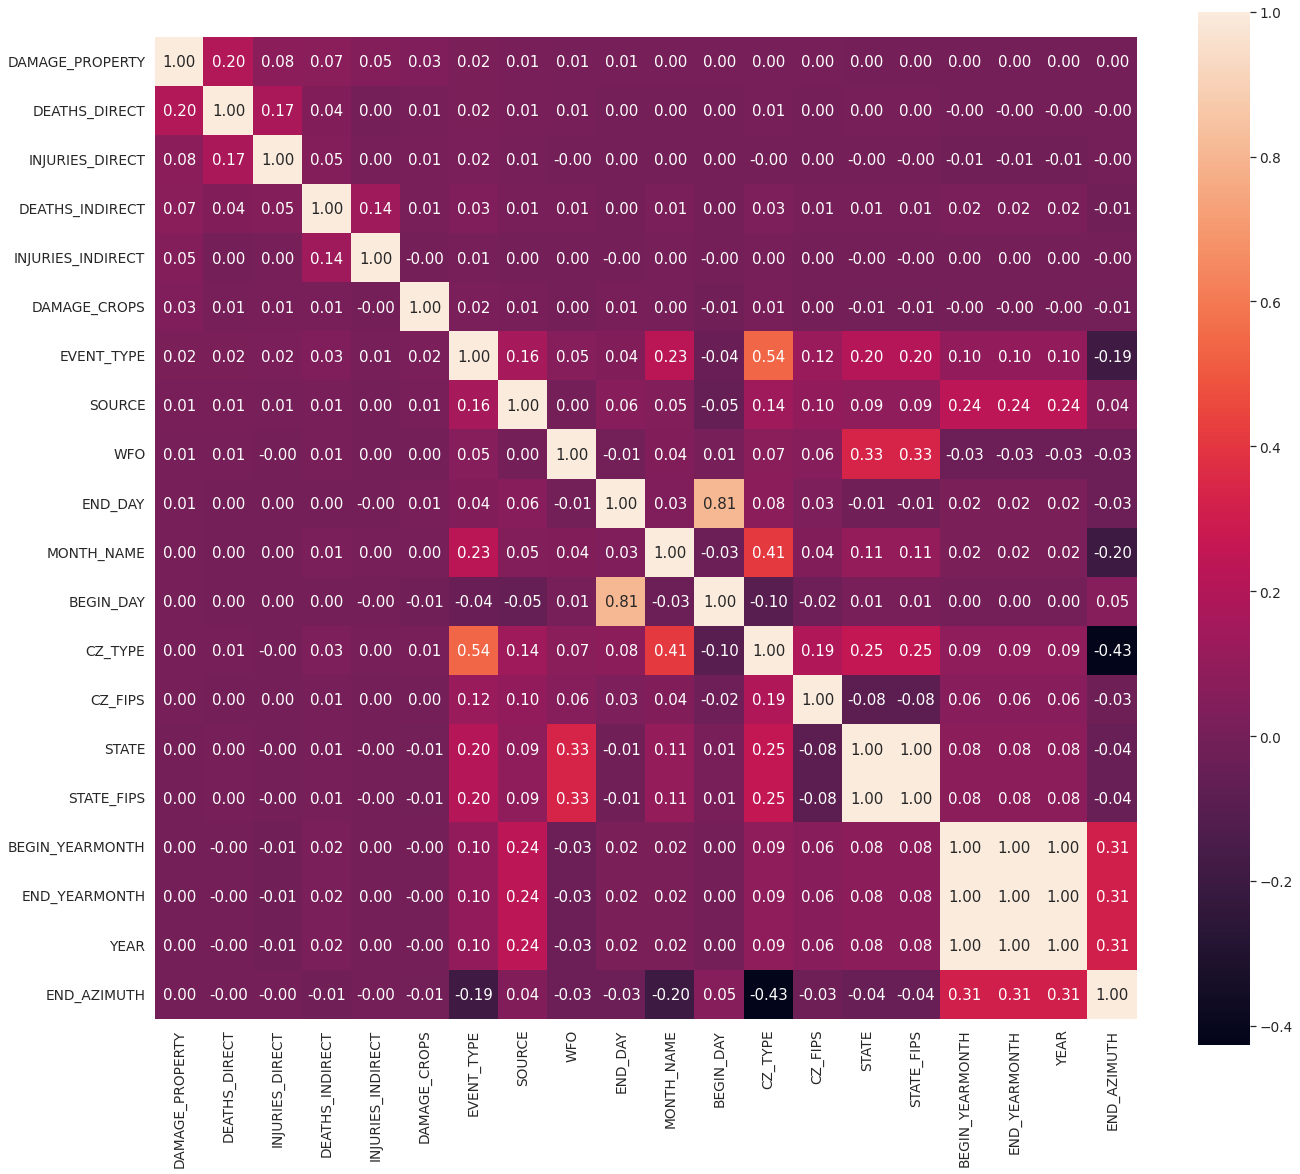

In [158]:
f, ax = plt.subplots(figsize=(22, 19))
# sns.heatmap(corrmat, vmax=1.0, square=True)
# plt.show()

#saleprice correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'DAMAGE_PROPERTY')['DAMAGE_PROPERTY'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
X = df_train.loc[:, ~df_train.columns.isin(['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'CZ_NAME', 'BEGIN_DATE_TIME','CZ_TIMEZONE', 'END_DATE_TIME', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_LOCATION', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON'])]

#X = df_train.loc[:, df_train.columns.isin(['DEATHS_DIRECT', 'DEATHS_INDIRECT', 'INJURIES_DIRECT', 'DAMAGE_CROPS'])]
Y = df_train['DAMAGE_PROPERTY']
# Y = df_train['DAMAGE_CROPS']

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)


# sc = StandardScaler()
# sc.fit(X_train)
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

print(X_train)

In [82]:
# pca = PCA(.95)
# pca.fit(X_train)


# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

# print(X_train.shape)

(505939, 25)


In [125]:
model = LinearRegression()
model.fit(X_train, y_train)

print(model)

# make predictions for test data
y_pred = model.predict(X_test)
y_pred_score = [round(value) for value in y_pred]

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

print(model.score(X_train,y_train))

print(r2_score(y_test, y_pred))


LinearRegression()
6883376039351.678
0.002670579666561812
0.002891178121424254


In [84]:
clf_rf = RandomForestRegressor(max_depth=10, random_state=0)

# perform training
clf_rf.fit(X_train, y_train)

# make predictions

# prediction on test using all features
y_pred = clf_rf.predict(X_test)

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

print(clf_rf.score(X_train,y_train))

print(r2_score(y_test, y_pred))

15.736253553254794
0.11562971421539947
0.11425458793229837


In [155]:
# rfc = XGBRegressor()

# parameters = {
#     'max_depth': range(2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

# xgb = GridSearchCV(rfc, parameters, cv=5, scoring='accuracy')


xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# print(xgb.feature_importances_)

# make predictions for test data
y_pred = xgb.predict(X_test)
y_pred_score = [round(value) for value in y_pred]

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

print(xgb.score(X_train,y_train))

print(r2_score(y_test, y_pred))

[23:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
744501522681661.1
0.39918462823809175
-0.06611420612750529


In [135]:
print(xgb.score(y_test, y_pred))

ValueError: ignored

In [14]:
clf_dt = DecisionTreeRegressor()

# perform training
clf_dt.fit(X_train, y_train)

# make predictions

# prediction on test using all features
y_pred = clf_dt.predict(X_test)

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

# print(1 - (1-clf_dt.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))


print(clf_dt.score(X_train,y_train))

1226827848157569.8
1.0


In [157]:
alpha_range = 10.**np.arange(-2, 3)

ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error')
ridgeregcv.fit(X_train, y_train)
ridgeregcv.alpha_

y_pred = ridgeregcv.predict(X_test)

print("R-Square Value",r2_score(y_test,y_pred))

R-Square Value 0.018503583945582158


In [99]:
lassoregcv = LassoCV(n_alphas=100, normalize=True, random_state=1)
lassoregcv.fit(X_train, y_train)
print('alpha : ',lassoregcv.alpha_)

y_pred = lassoregcv.predict(X_test)

print("R-Square Value",r2_score(y_test,y_pred))

alpha :  1.6486561240176785e-06
R-Square Value 0.1676204583374864
